In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv
/kaggle/input/nlp-getting-started/sample_submission.csv


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
from collections import  Counter
plt.style.use('ggplot')
stop=set(stopwords.words('english'))
import re
from nltk.tokenize import word_tokenize
import gensim
import string

In [4]:
df = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')

In [4]:
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [5]:
df['text'].isnull().sum()

0

In [10]:
df.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


In [11]:
df['text']

0       Our Deeds are the Reason of this #earthquake M...
1                  Forest fire near La Ronge Sask. Canada
2       All residents asked to 'shelter in place' are ...
3       13,000 people receive #wildfires evacuation or...
4       Just got sent this photo from Ruby #Alaska as ...
                              ...                        
7608    Two giant cranes holding a bridge collapse int...
7609    @aria_ahrary @TheTawniest The out of control w...
7610    M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...
7611    Police investigating after an e-bike collided ...
7612    The Latest: More Homes Razed by Northern Calif...
Name: text, Length: 7613, dtype: object

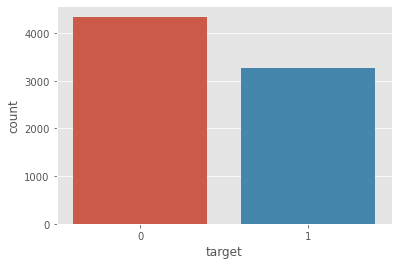

In [14]:
sns.countplot(df.target)

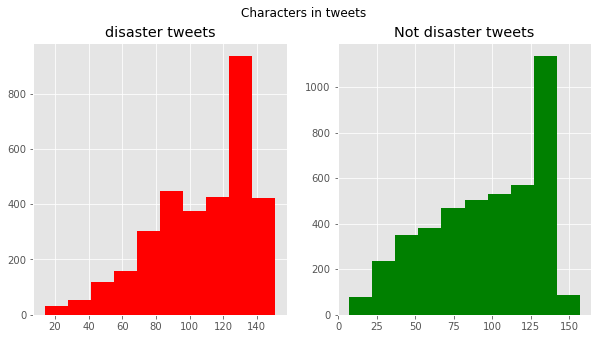

In [15]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=df[df['target']==1]['text'].str.len()
ax1.hist(tweet_len,color='red')
ax1.set_title('disaster tweets')
tweet_len=df[df['target']==0]['text'].str.len()
ax2.hist(tweet_len,color='green')
ax2.set_title('Not disaster tweets')
fig.suptitle('Characters in tweets')
plt.show()

Text(0.5, 0.98, 'Average word length in each tweet')

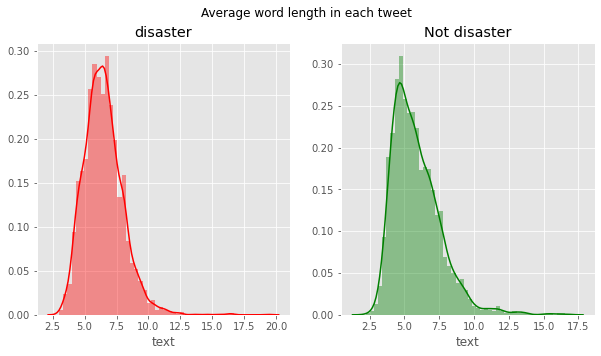

In [17]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
word=df[df['target']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('disaster')
word=df[df['target']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('Not disaster')
fig.suptitle('Average word length in each tweet')

In [21]:
def create_corpus(target):
    corpus=[]
    
    for x in df[df['target']==target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

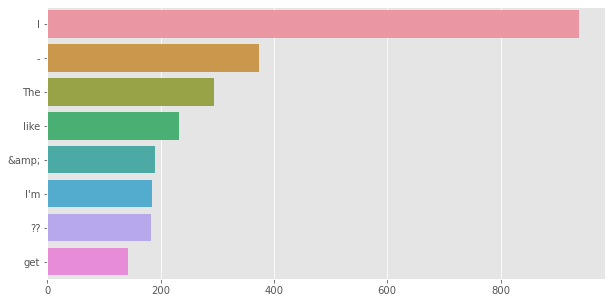

In [23]:
plt.figure(figsize=(10,5))
corpus=create_corpus(0)

counter=Counter(corpus)
most=counter.most_common()
x=[]
y=[]
for word,count in most[:40]:
    if (word not in stop) :
        x.append(word)
        y.append(count)
        
sns.barplot(x=y,y=x)

In [6]:
train = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
test = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')

In [30]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [25]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [9]:
def cleaner(phrase):
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can't", 'can not', phrase)
  
  # general
    phrase = re.sub(r"n\'t"," not", phrase)
    phrase = re.sub(r"\'re'"," are", phrase)
    phrase = re.sub(r"\'s"," is", phrase)
    phrase = re.sub(r"\'ll"," will", phrase)
    phrase = re.sub(r"\'d"," would", phrase)
    phrase = re.sub(r"\'t"," not", phrase)
    phrase = re.sub(r"\'ve"," have", phrase)
    phrase = re.sub(r"\'m"," am", phrase)
    
    return phrase

In [10]:
from bs4 import BeautifulSoup
from tqdm import tqdm
import re

import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
stop = set(stopwords.words('english'))
len(stop)

179

In [26]:
cleaned_text = []

for sentance in tqdm(train['text'].values):
    sentance = str(sentance)
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = cleaner(sentance)
    sentance = re.sub(r'[?|!|\'|"|#|+]', r'', sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stop)
    cleaned_text.append(sentance.strip())

100%|██████████| 7613/7613 [00:02<00:00, 2741.13it/s]


In [56]:
cleaned_text1 = []

for sentance in tqdm(test['text'].values):
    sentance = str(sentance)
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = cleaner(sentance)
    sentance = re.sub(r'[?|!|\'|"|#|+]', r'', sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stop)
    cleaned_text1.append(sentance.strip())

100%|██████████| 3263/3263 [00:01<00:00, 2710.21it/s]


In [57]:
test['text'] = cleaned_text1

In [27]:
train['text'] = cleaned_text

In [28]:
X = train['text']
Y = train['target']

In [38]:
X.isnull().sum()

0

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [32]:
from sklearn.model_selection import train_test_split
X_Train, X_cross, y_Train, y_cross = train_test_split(X, Y, test_size=0.1, random_state=42)

In [33]:
tf_idf = TfidfVectorizer(ngram_range=(1,2))

In [39]:
tf_idf.fit(X_Train)
Train_TFIDF = tf_idf.transform(X_Train)
CrossVal_TFIDF = tf_idf.transform(X_cross)
#Test_TFIDF= tf_idf.transform(X_test)

In [61]:
Test_TFIDF= tf_idf.transform(test['text'])

In [43]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report

from sklearn.linear_model import LogisticRegression

In [80]:
c=[0.0001,0.001,0.01,0.1,1,10,100,1000]
Train_AUC_TFIDF = []
CrossVal_AUC_TFIDF = []
for i in c:
    logreg = LogisticRegression(C=i,penalty='l2')
    logreg.fit(Train_TFIDF, y_Train)
    Train_y_pred =  logreg.predict(Train_TFIDF)
    Train_AUC_TFIDF.append(roc_auc_score(y_Train ,Train_y_pred))
    CrossVal_y_pred =  logreg.predict(CrossVal_TFIDF)
    CrossVal_AUC_TFIDF.append(roc_auc_score(y_cross,CrossVal_y_pred))

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [81]:
from numpy import math

C=[]
for i in range(len(c)):
    C.append(math.log(c[i]))

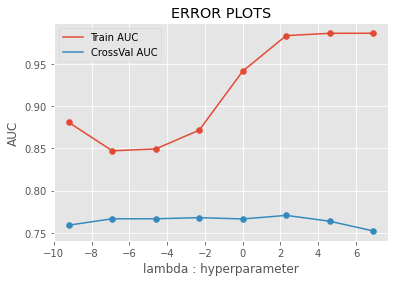

In [82]:
plt.plot(C, Train_AUC_TFIDF, label='Train AUC')
plt.scatter(C, Train_AUC_TFIDF)
plt.plot(C, CrossVal_AUC_TFIDF, label='CrossVal AUC')
plt.scatter(C, CrossVal_AUC_TFIDF)
plt.legend()
plt.xlabel("lambda : hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [83]:
optimal_inverse_lambda=c[CrossVal_AUC_TFIDF.index(max(CrossVal_AUC_TFIDF))]
print(pow(optimal_inverse_lambda,-1))

0.1


In [84]:
Classifier=LogisticRegression(C=optimal_inverse_lambda,penalty='l2')
Classifier.fit(Train_TFIDF, y_Train)

LogisticRegression(C=10)

In [86]:
print('Confusion Matrix of Train Data')
Train_mat=confusion_matrix(y_Train,Classifier.predict(Train_TFIDF))
print (Train_mat)

Confusion Matrix of Train Data
[[3884   32]
 [  73 2862]]


In [53]:
from sklearn import metrics
print(metrics.classification_report(y_Train,Classifier.predict(Train_TFIDF)))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      3916
           1       0.99      0.98      0.98      2935

    accuracy                           0.99      6851
   macro avg       0.99      0.99      0.99      6851
weighted avg       0.99      0.99      0.99      6851



In [85]:
print ("Accuracy is: ", metrics.accuracy_score(y_Train,Classifier.predict(Train_TFIDF)))

Accuracy is:  0.9846737702525179


In [66]:
c=[0.0001,0.001,0.01,0.1,1,10,100,1000]
Train_AUC_TFIDF_l1 = []
CrossVal_AUC_TFIDF_l1 = []
for i in c:
    logreg = LogisticRegression(C=i,penalty='l1',solver =  'liblinear')
    logreg.fit(Train_TFIDF, y_Train)
    Train_y_pred =  logreg.predict(Train_TFIDF)
    Train_AUC_TFIDF_l1.append(roc_auc_score(y_Train ,Train_y_pred))
    CrossVal_y_pred =  logreg.predict(CrossVal_TFIDF)
    CrossVal_AUC_TFIDF_l1.append(roc_auc_score(y_cross,CrossVal_y_pred))

/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


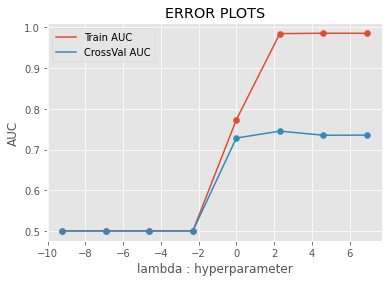

In [67]:
plt.plot(C, Train_AUC_TFIDF_l1, label='Train AUC')
plt.scatter(C, Train_AUC_TFIDF_l1)
plt.plot(C, CrossVal_AUC_TFIDF_l1, label='CrossVal AUC')
plt.scatter(C, CrossVal_AUC_TFIDF_l1)
plt.legend()
plt.xlabel("lambda : hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [68]:
optimal_inverse_lambda=c[CrossVal_AUC_TFIDF_l1.index(max(CrossVal_AUC_TFIDF_l1))]
print(pow(optimal_inverse_lambda,-1))

0.1


In [70]:
Classifier1=LogisticRegression(C=optimal_inverse_lambda, penalty='l1',solver =  'liblinear')
Classifier1.fit(Train_TFIDF, y_Train)

/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LogisticRegression(C=10, penalty='l1', solver='liblinear')

In [71]:
print ("Accuracy is: ", metrics.accuracy_score(y_Train,Classifier1.predict(Train_TFIDF)))

Accuracy is:  0.9856955189023501


In [72]:
from sklearn.naive_bayes import MultinomialNB

In [74]:
alpha_set=[0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000]

Train_AUC_TFIDF = []
CrossVal_AUC_TFIDF = []


for i in alpha_set:
    naive_b=MultinomialNB(alpha=i)
    naive_b.fit(Train_TFIDF, y_Train)
    Train_y_pred =  naive_b.predict(Train_TFIDF)
    Train_AUC_TFIDF.append(roc_auc_score(y_Train,Train_y_pred))
    CrossVal_y_pred =  naive_b.predict(CrossVal_TFIDF)
    CrossVal_AUC_TFIDF.append(roc_auc_score(y_cross,CrossVal_y_pred))

In [75]:
Alpha_set=[]
for i in range(len(alpha_set)):
    Alpha_set.append(math.log(alpha_set[i]))

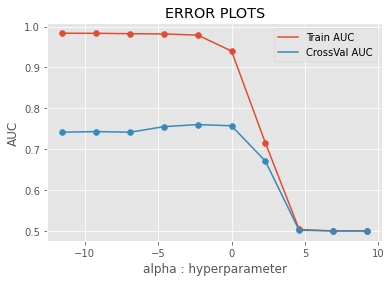

In [76]:
plt.plot(Alpha_set, Train_AUC_TFIDF, label='Train AUC')
plt.scatter(Alpha_set, Train_AUC_TFIDF)
plt.plot(Alpha_set, CrossVal_AUC_TFIDF, label='CrossVal AUC')
plt.scatter(Alpha_set, CrossVal_AUC_TFIDF)
plt.legend()
plt.xlabel("alpha : hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [77]:
optimal_alpha=alpha_set[CrossVal_AUC_TFIDF.index(max(CrossVal_AUC_TFIDF))]
print(optimal_alpha)

0.1


In [78]:
Classifier2 = MultinomialNB(alpha=optimal_alpha)
Classifier2.fit(Train_TFIDF, y_Train)

MultinomialNB(alpha=0.1)

In [79]:
print ("Accuracy is: ", metrics.accuracy_score(y_Train,Classifier2.predict(Train_TFIDF)))

Accuracy is:  0.9802948474675229


In [59]:
sample = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")

In [62]:
sample['target'] = Classifier.predict(Test_TFIDF)

In [63]:
sample.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [64]:
# Submission
sample.to_csv("submission.csv", index=False)